In [ ]:
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.layers import Dense,Flatten,Dropout,BatchNormalization,LeakyReLU,Conv2DTranspose,Input,Reshape,Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [ ]:
(x_train,y_train),(x_test,y_test) = tensorflow.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
def show_img(img):
  plt.figure(figsize=(8,8))
  plt.imshow(img)
  plt.show()

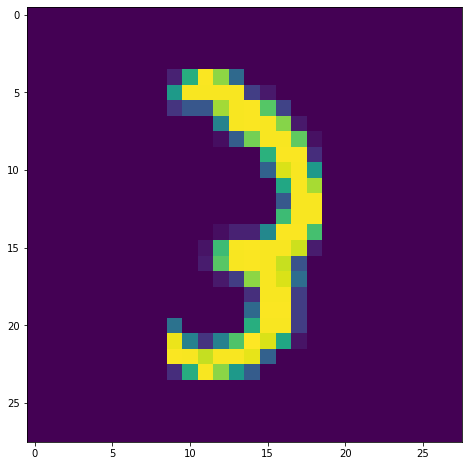

In [ ]:
show_img(x_train[np.random.randint(0,len(x_train))])

In [ ]:
img_size = x_train[0].shape

In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5

In [ ]:
latent_space = 800
N,H,W,E = x_train.shape
D = H*W

In [ ]:
def generator_model(latent_space):
  moment = 0.8
  i = Input(shape = (latent_space,))
  x = Dense(7*7*256,use_bias = False)(i)
  x = BatchNormalization(momentum = moment)(x)
  x = LeakyReLU(0.3)(x)

  x = Reshape((7,7,256))(x)
  x = Conv2DTranspose(128,(5,5),strides = (1,1), padding = "same", use_bias = False)(x)
  x = BatchNormalization(momentum = moment)(x)
  x = LeakyReLU(0.3)(x)

  x = Conv2DTranspose(64,(5,5),strides = (2,2), padding = "same", use_bias = False)(x)
  x = BatchNormalization(momentum = moment)(x)
  x = LeakyReLU(0.3)(x)

  x = Conv2DTranspose(1,(5,5),strides = (2,2), padding = "same", use_bias = False,activation = "tanh")(x)

  model = Model(i,x,name = "generator")
  return model 

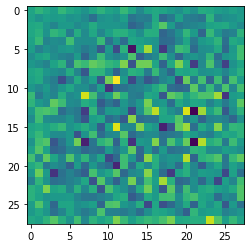

In [ ]:
gen = generator_model(latent_space)
noise = tensorflow.random.normal([1, latent_space])
generated_image = gen(noise, training=False)
plt.imshow(generated_image[0,:,:,0])
gen_out = gen.output_shape[1:]

In [ ]:
def discriminator_model(gen_out = gen_out):
  i = Input(shape = (gen_out))
  x = Conv2D(64,(5,5),strides = (2,2),padding = "same",activation = LeakyReLU(0.3))(i)
  x = Dropout(0.2)(x)
  x = Conv2D(128,(5,5),strides = (2,2),padding = "same",activation = LeakyReLU(0.3))(x)
  x = Dropout(0.2)(x)
  x = Flatten()(x)
  x = Dense(1,activation = "sigmoid")(x)
  model = Model(i,x,name = "discriminator")
  return model

In [ ]:
dis = discriminator_model()

In [ ]:
dis.compile(optimizer = Adam(0.0003,0.5), loss = "binary_crossentropy", metrics = ["accuracy"])

z = Input(shape = (latent_space,))
img = gen(z)
dis.trainable = False
fake_pred = dis(img)
c_model = Model(z,fake_pred)

In [ ]:
c_model.compile(optimizer = Adam(0.0003,0.5),loss = "binary_crossentropy")

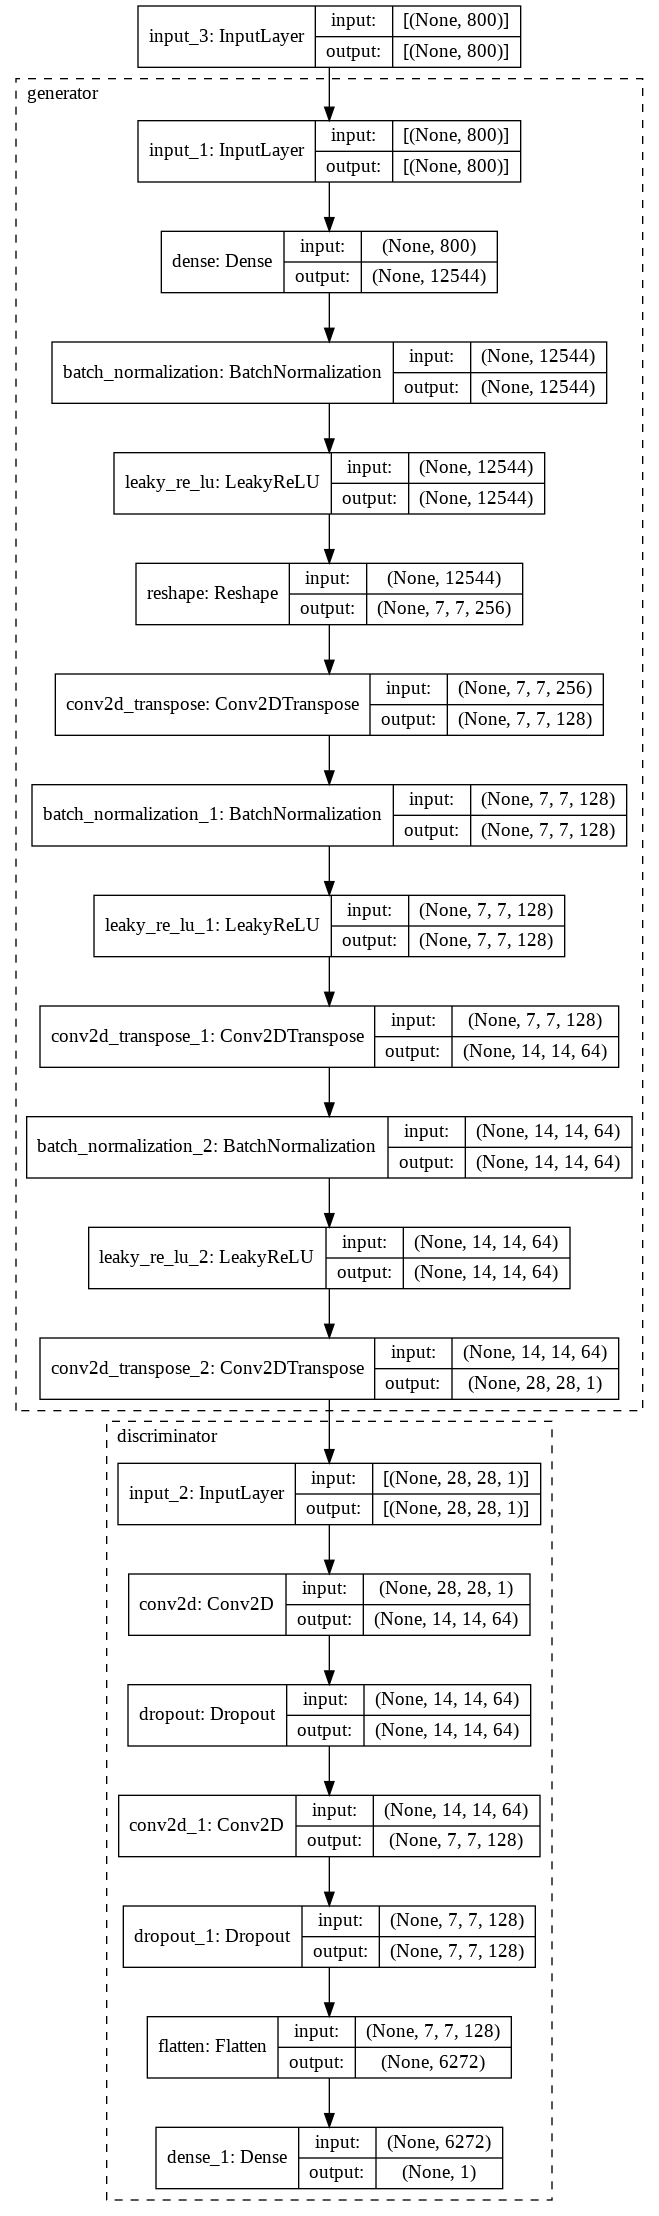

In [ ]:
tensorflow.keras.utils.plot_model(c_model, show_shapes = True, expand_nested = True)

In [ ]:
import os,sys
batch_size = 64
epochs = 50000
sample_period = 500

zeros = np.zeros(batch_size)
ones = np.ones(batch_size)

g_losses = []
d_losses = []

if not os.path.exists("gan_images"):
  os.makedirs("gan_images")

In [ ]:
def sample_images(epoch):
  rows,cols = 5,5
  noise = np.random.randn(rows*cols,latent_space)
  imgs = gen.predict(noise)
  imgs = 0.5 * imgs + 0.5
  fig,axes = plt.subplots(rows,cols)
  index = 0
  for row in range(rows):
    for col in range(cols):
      axes[row,col].imshow(imgs[index].reshape(H,W))
      axes[row,col].axis("off")
      index = index + 1
  fig.savefig(f"gan_images/{epoch}.png")
  plt.close()

In [ ]:
for epoch in range(epochs):
  #----------train discriminator------------
  index = np.random.randint(0,x_train.shape[0],batch_size)
  real_imgs = x_train[index]
  #fake_samples
  noise = np.random.randn(batch_size,latent_space)
  fake_imgs = gen.predict(noise)

  #dis_train

  d_loss_r,d_acc_r = dis.train_on_batch(real_imgs,y = ones)
  d_loss_f,d_acc_f = dis.train_on_batch(fake_imgs,y = zeros)
  d_loss = 0.5 * (d_loss_r + d_loss_f)
  d_acc = 0.5 * (d_acc_r + d_acc_f)

  #--------------train generator--------------
  noise = np.random.randn(batch_size,latent_space)
  g_loss = c_model.train_on_batch(noise,ones)

  g_losses.append(g_loss)
  d_losses.append(d_loss)

  if epoch % 300 == 0 :
    print(f"epoch : {epoch+1}/{epochs}  D-loss : {d_loss} D-acc : {d_acc} G-loss : {g_loss}  hail 💘 HYDRA 💘")

  if epoch % sample_period == 0:
    sample_images(epoch)

epoch : 1/50000  D-loss : 0.7212893962860107 D-acc : 0.0390625 G-loss : 0.634411633014679  hail 💘 HYDRA 💘
epoch : 301/50000  D-loss : 0.7122614979743958 D-acc : 0.375 G-loss : 0.6958562135696411  hail 💘 HYDRA 💘
epoch : 601/50000  D-loss : 0.68047696352005 D-acc : 0.578125 G-loss : 0.7229863405227661  hail 💘 HYDRA 💘
epoch : 901/50000  D-loss : 0.6970289349555969 D-acc : 0.4765625 G-loss : 0.737521231174469  hail 💘 HYDRA 💘
epoch : 1201/50000  D-loss : 0.6657504439353943 D-acc : 0.6171875 G-loss : 0.7343732118606567  hail 💘 HYDRA 💘
epoch : 1501/50000  D-loss : 0.6888002753257751 D-acc : 0.578125 G-loss : 0.7625574469566345  hail 💘 HYDRA 💘
epoch : 1801/50000  D-loss : 0.6719145178794861 D-acc : 0.625 G-loss : 0.856916606426239  hail 💘 HYDRA 💘
epoch : 2101/50000  D-loss : 0.679600864648819 D-acc : 0.5234375 G-loss : 0.7545085549354553  hail 💘 HYDRA 💘
epoch : 2401/50000  D-loss : 0.7173934578895569 D-acc : 0.4375 G-loss : 0.7325422763824463  hail 💘 HYDRA 💘
epoch : 2701/50000  D-loss : 0.6738

In [ ]:
!ls gan_images

0.png	   16000.png  23000.png  30000.png  36500.png  43500.png  500.png
10000.png  16500.png  23500.png  3000.png   37000.png  44000.png  5500.png
1000.png   17000.png  24000.png  30500.png  37500.png  44500.png  6000.png
10500.png  17500.png  24500.png  31000.png  38000.png  45000.png  6500.png
11000.png  18000.png  25000.png  31500.png  38500.png  4500.png   7000.png
11500.png  18500.png  2500.png	 32000.png  39000.png  45500.png  7500.png
12000.png  19000.png  25500.png  32500.png  39500.png  46000.png  8000.png
12500.png  19500.png  26000.png  33000.png  40000.png  46500.png  8500.png
13000.png  20000.png  26500.png  33500.png  4000.png   47000.png  9000.png
13500.png  2000.png   27000.png  34000.png  40500.png  47500.png  9500.png
14000.png  20500.png  27500.png  34500.png  41000.png  48000.png
14500.png  21000.png  28000.png  35000.png  41500.png  48500.png
15000.png  21500.png  28500.png  3500.png   42000.png  49000.png
1500.png   22000.png  29000.png  35500.png  42500.png  4950

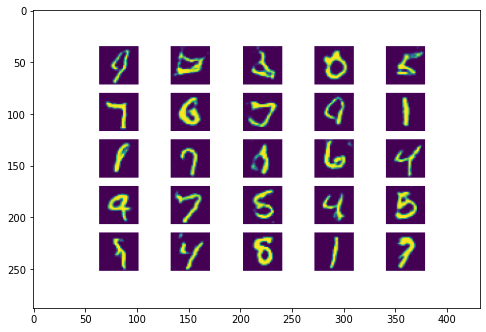

In [ ]:
from skimage.io import imread
show_img(imread("gan_images/19500.png"))